# **Import needed libraries**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import system libs
import os
import itertools

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

# **Loading the dataset**

> Read the training dataset into the dataframe

In [ ]:
# Generate data paths with labels
train_data_dir = "/content/drive/MyDrive/DIVP/Training"
filepaths = []
labels = []

# Get folders names
folds = os.listdir(train_data_dir)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

train_df = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
train_df

,filepaths,labels
0,/content/drive/MyDrive/DIVP/Training/glioma/Tr...,glioma
1,/content/drive/MyDrive/DIVP/Training/glioma/Tr...,glioma
2,/content/drive/MyDrive/DIVP/Training/glioma/Tr...,glioma
3,/content/drive/MyDrive/DIVP/Training/glioma/Tr...,glioma
4,/content/drive/MyDrive/DIVP/Training/glioma/Tr...,glioma
...,...,...
5707,/content/drive/MyDrive/DIVP/Training/notumor/T...,notumor
5708,/content/drive/MyDrive/DIVP/Training/notumor/T...,notumor
5709,/content/drive/MyDrive/DIVP/Training/notumor/T...,notumor
5710,/content/drive/MyDrive/DIVP/Training/notumor/T...,notumor


> read the testing dataset into the dataframe

In [ ]:
# Generate data paths with labels
test_data_dir = '/content/drive/MyDrive/DIVP/Testing'
filepaths = []
labels = []

# Get folders names
folds = os.listdir(test_data_dir)

for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

ts_df = pd.concat([Fseries, Lseries], axis= 1)


In [ ]:
ts_df

,filepaths,labels
0,/content/drive/MyDrive/DIVP/Testing/meningioma...,meningioma
1,/content/drive/MyDrive/DIVP/Testing/meningioma...,meningioma
2,/content/drive/MyDrive/DIVP/Testing/meningioma...,meningioma
3,/content/drive/MyDrive/DIVP/Testing/meningioma...,meningioma
4,/content/drive/MyDrive/DIVP/Testing/meningioma...,meningioma
...,...,...
1306,/content/drive/MyDrive/DIVP/Testing/notumor/Te...,notumor
1307,/content/drive/MyDrive/DIVP/Testing/notumor/Te...,notumor
1308,/content/drive/MyDrive/DIVP/Testing/notumor/Te...,notumor
1309,/content/drive/MyDrive/DIVP/Testing/notumor/Te...,notumor


# **Data preprocessing**

first we will check if the training data is balanced or not

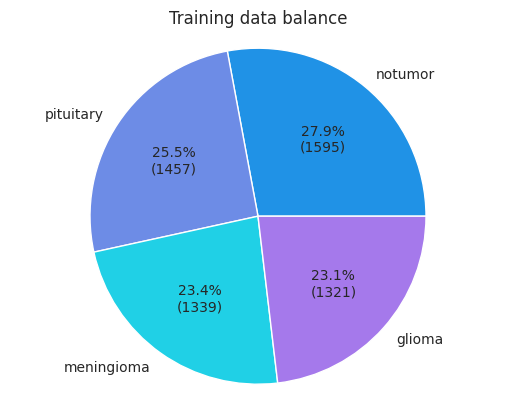

In [ ]:
data_balance = train_df.labels.value_counts()


def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)


# pie chart for data balance
plt.pie(data_balance, labels = data_balance.index, autopct=custom_autopct, colors = ["#2092E6","#6D8CE6","#20D0E6","#A579EB"])
plt.title("Training data balance")
plt.axis("equal")
plt.show()

**data is balanced.**

**now we will split the testing data to test and validation data**

In [ ]:
# valid and test dataframe
valid_df, test_df = train_test_split(ts_df,  train_size= 0.5, shuffle= True, random_state= 42)

**Create image data generator**

this step to convert these dataframes to numpy array

In [ ]:
# crobed image size
batch_size = 16
img_size = (224, 224)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


**Display sample from train data**

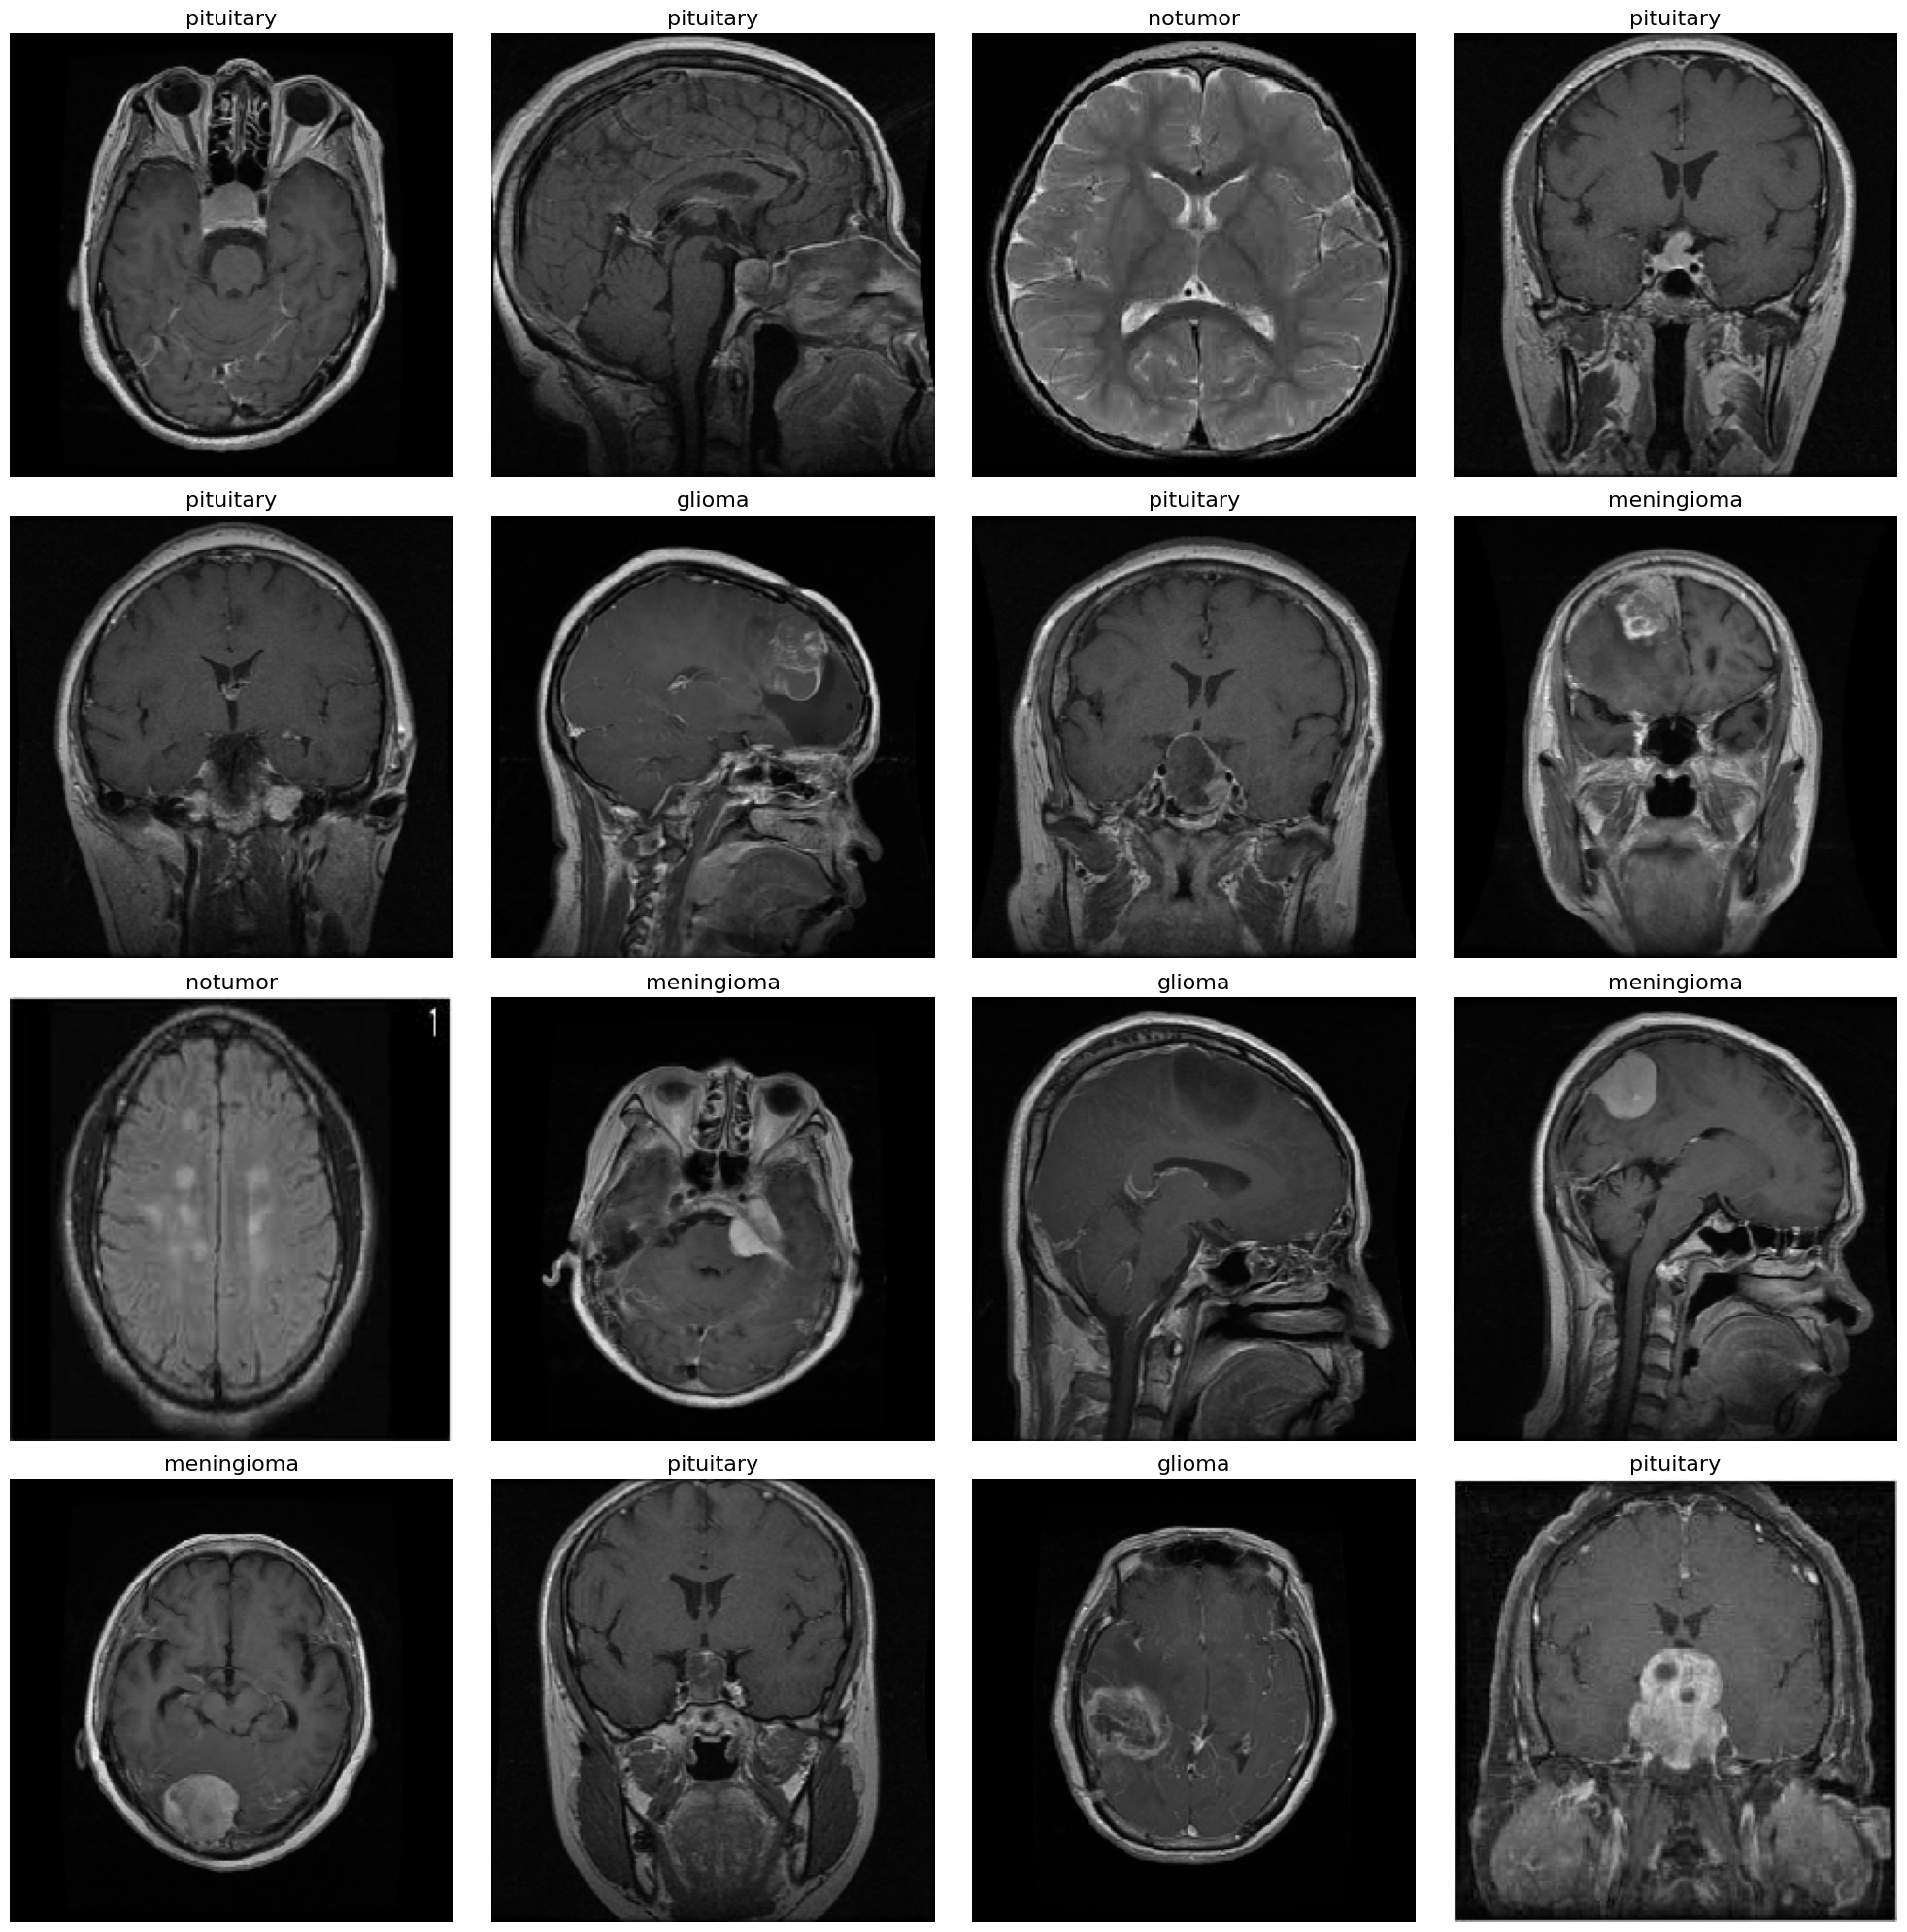

In [ ]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator
# # difference between next iterator and for iterator


plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'black', fontsize= 16)
    plt.axis('off')
plt.tight_layout()
plt.show()

# **Model Structure**

In [ ]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape))
model.add(MaxPooling2D())

model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(64,activation = "relu"))
model.add(Dense(32,activation = "relu"))
model.add(Dense(class_count, activation = "softmax"))


In [ ]:
# Compile model
model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    12,845,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,866,724 (49.08 MB)

 Trainable params: 12,866,724 (49.08 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 10   # number of all epochs in training

history = model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 2109s 6s/step - accuracy: 0.6716 - loss: 38.3499 - val_accuracy: 0.8794 - val_loss: 0.3515
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 29s 82ms/step - accuracy: 0.9512 - loss: 0.1824 - val_accuracy: 0.9191 - val_loss: 0.2554
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 32s 88ms/step - accuracy: 0.9857 - loss: 0.0591 - val_accuracy: 0.9420 - val_loss: 0.2125
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 29s 81ms/step - accuracy: 0.9953 - loss: 0.0279 - val_accuracy: 0.9267 - val_loss: 0.2639
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 29s 81ms/step - accuracy: 0.9972 - loss: 0.0173 - val_accuracy: 0.9450 - val_loss: 0.2256
Epoch 6/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 29s 82ms/step - accuracy: 0.9991 - loss: 0.0057 - val_accuracy: 0.9374 - val_loss: 0.2884
Epoch 7/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 29s 81ms/step - accuracy: 0.9985 - loss: 0.0073 - val_accuracy: 0.9496 - val_loss: 0.2262
Epoch 8/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 30s 84ms/step - accuracy: 0.9973 - loss: 0.0110 -

In [ ]:
# Create a new MLP model
model2 = Sequential([
    Flatten(input_shape=img_shape),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(class_count, activation='softmax')
])

model2.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history2 = model2.fit(train_gen, epochs=epochs, verbose=1, validation_data=valid_gen, shuffle=False)

Epoch 1/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 31s 81ms/step - accuracy: 0.5377 - loss: 909.9954 - val_accuracy: 0.7527 - val_loss: 194.5397
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 28s 78ms/step - accuracy: 0.7332 - loss: 143.3709 - val_accuracy: 0.7450 - val_loss: 211.1592
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 28s 79ms/step - accuracy: 0.7689 - loss: 116.9479 - val_accuracy: 0.7527 - val_loss: 134.8056
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 40s 77ms/step - accuracy: 0.7629 - loss: 113.2598 - val_accuracy: 0.6977 - val_loss: 181.3685
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 28s 77ms/step - accuracy: 0.7639 - loss: 102.6986 - val_accuracy: 0.7710 - val_loss: 99.5527
Epoch 6/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 28s 78ms/step - accuracy: 0.8140 - loss: 57.6729 - val_accuracy: 0.6794 - val_loss: 120.2521
Epoch 7/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 28s 79ms/step - accuracy: 0.7795 - loss: 61.6973 - val_accuracy: 0.7863 - val_loss: 57.3991
Epoch 8/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 28s 77ms/step - accuracy: 

In [ ]:
# Print model summary
model2.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │    19,267,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,828,686 (220.60 MB)

 Trainable params: 19,276,228 (73.53 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 38,552,458 (147.07 MB)

In [ ]:
# Load the VGG16 model without the top (fully connected) layers
vgg_base = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=img_shape)

# Freeze the VGG16 base model
vgg_base.trainable = False

# Create a new model on top of the VGG16 base
model3 = Sequential([
    vgg_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(class_count, activation='softmax')
])

model3.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history3 = model3.fit(train_gen, epochs=epochs, verbose=1, validation_data=valid_gen, shuffle=False)



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 61s 141ms/step - accuracy: 0.7896 - loss: 6.9650 - val_accuracy: 0.8473 - val_loss: 0.8016
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 41s 116ms/step - accuracy: 0.9620 - loss: 0.1353 - val_accuracy: 0.9405 - val_loss: 0.2128
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 116ms/step - accuracy: 0.9788 - loss: 0.0686 - val_accuracy: 0.9725 - val_loss: 0.1419
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 41s 116ms/step - accuracy: 0.9835 - loss: 0.0476 - val_accuracy: 0.9710 - val_loss: 0.1013
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 116ms/step - accuracy: 0.9908 - loss: 0.0277 - val_accuracy: 0.9786 - val_loss: 0.0821
Epoch 6/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 116ms/step - accuracy: 0.9964 - loss: 0.0099 - val_accuracy: 0.9878 - val_loss: 0.0456
Epoch 7/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 41s 116ms/step - accuracy: 0.9994 - loss: 0.0024 - val_accuracy: 0.9786 - val_loss: 0.0742
Epoch 8/10
357/357 ━━━━━━━━━━━━━

In [ ]:
# Print model summary
model3.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,986,126 (129.65 MB)

 Trainable params: 6,423,812 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 12,847,626 (49.01 MB)

## Display Model Performance

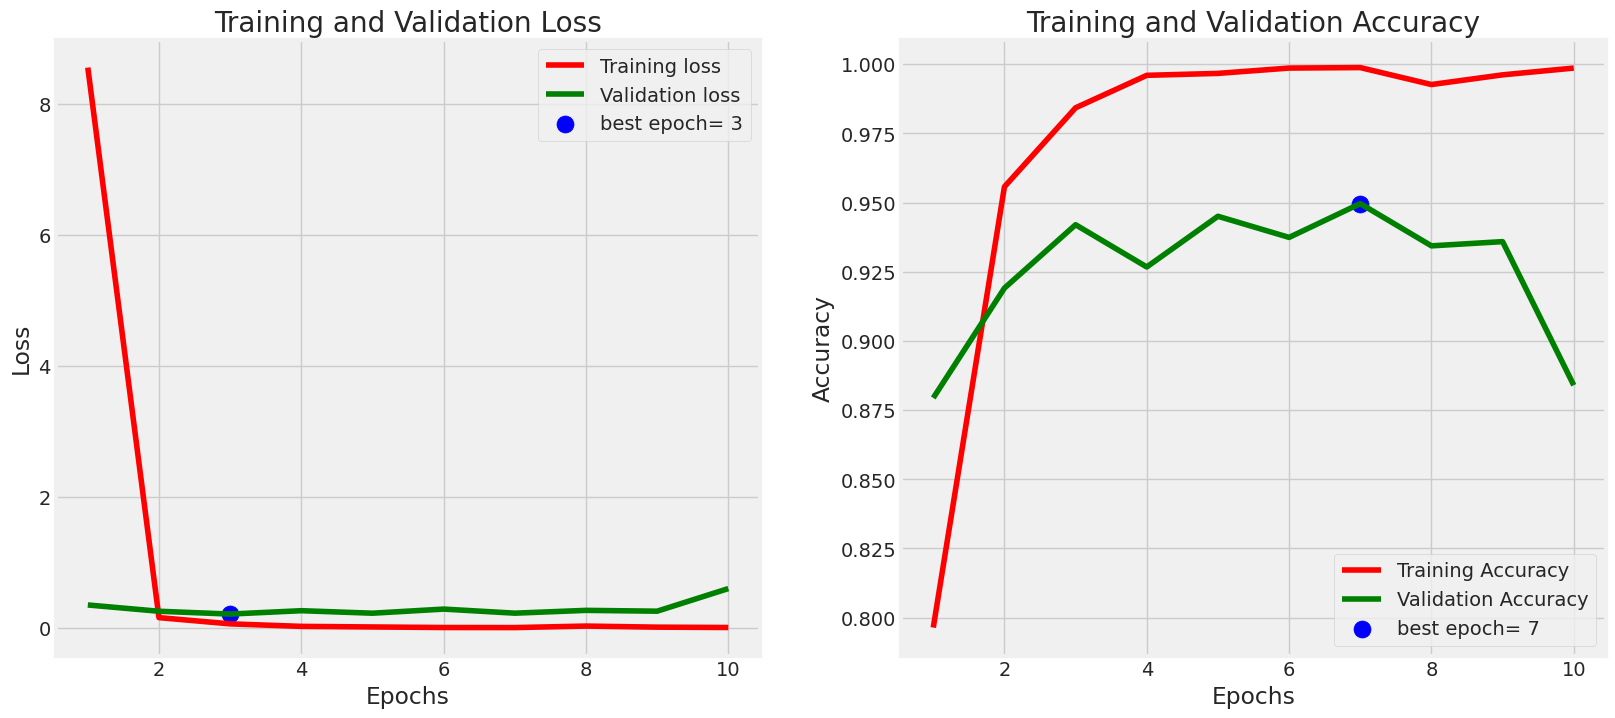

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

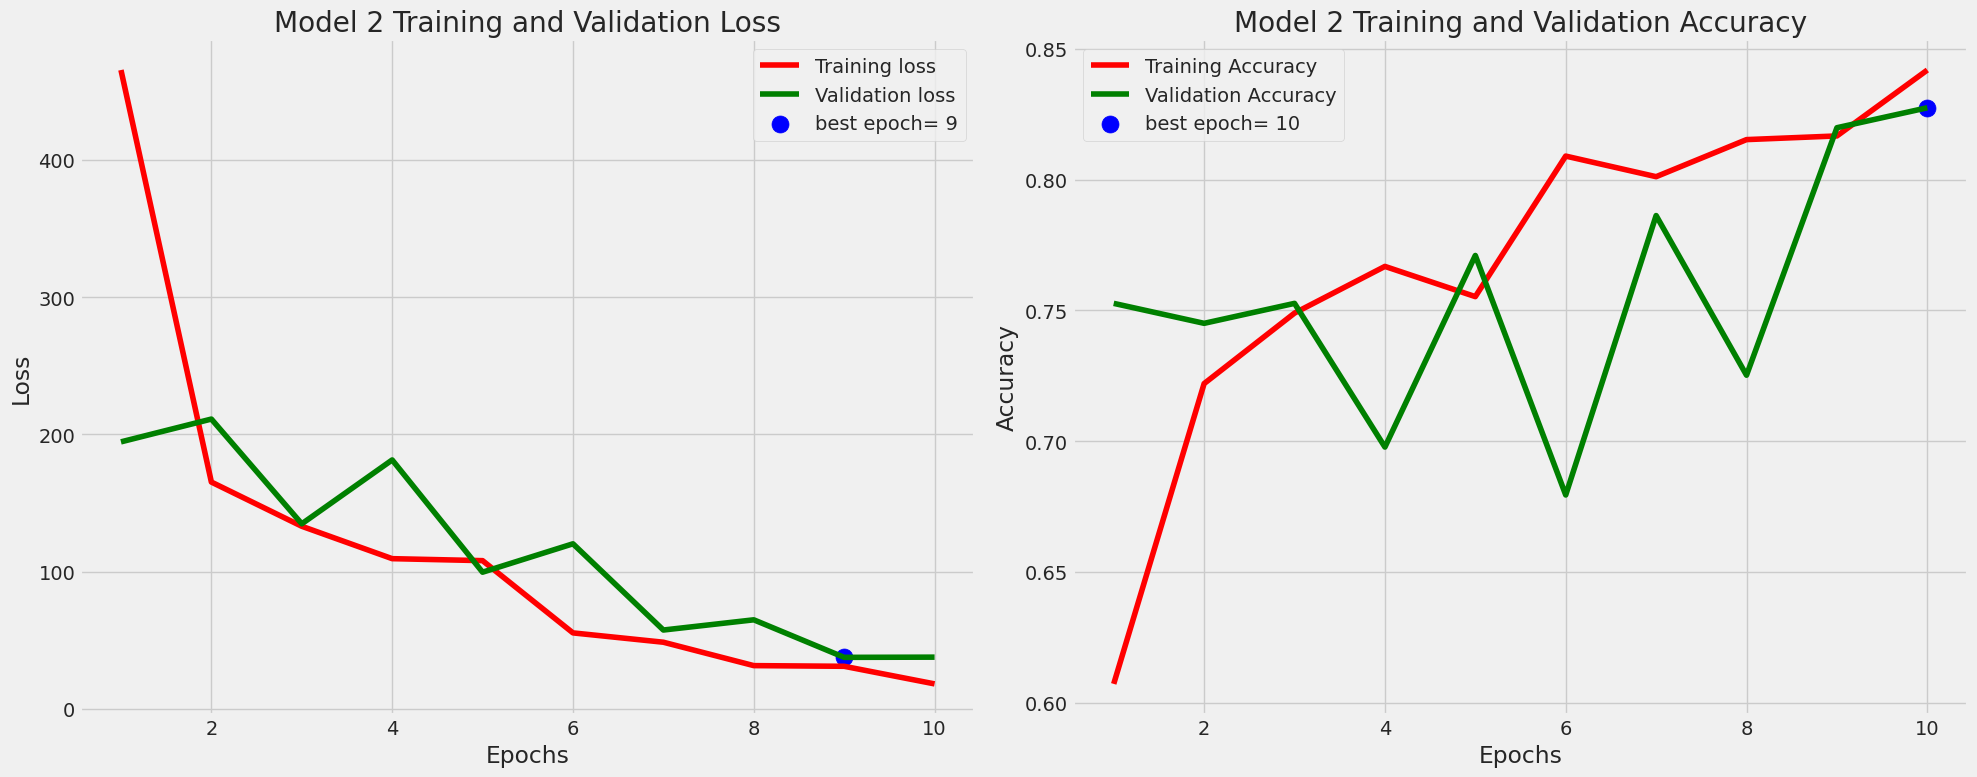

In [ ]:
# Define needed variables for model2
tr_acc_model2 = history2.history['accuracy']
tr_loss_model2 = history2.history['loss']
val_acc_model2 = history2.history['val_accuracy']
val_loss_model2 = history2.history['val_loss']
index_loss_model2 = np.argmin(val_loss_model2)
val_lowest_model2 = val_loss_model2[index_loss_model2]
index_acc_model2 = np.argmax(val_acc_model2)
acc_highest_model2 = val_acc_model2[index_acc_model2]

Epochs_model2 = [i+1 for i in range(len(tr_acc_model2))]
loss_label_model2 = f'best epoch= {str(index_loss_model2 + 1)}'
acc_label_model2 = f'best epoch= {str(index_acc_model2 + 1)}'

# Plot training history for model2
plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs_model2, tr_loss_model2, 'r', label='Training loss')
plt.plot(Epochs_model2, val_loss_model2, 'g', label='Validation loss')
plt.scatter(index_loss_model2 + 1, val_lowest_model2, s=150, c='blue', label=loss_label_model2)
plt.title('Model 2 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs_model2, tr_acc_model2, 'r', label='Training Accuracy')
plt.plot(Epochs_model2, val_acc_model2, 'g', label='Validation Accuracy')
plt.scatter(index_acc_model2 + 1, acc_highest_model2, s=150, c='blue', label=acc_label_model2)
plt.title('Model 2 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


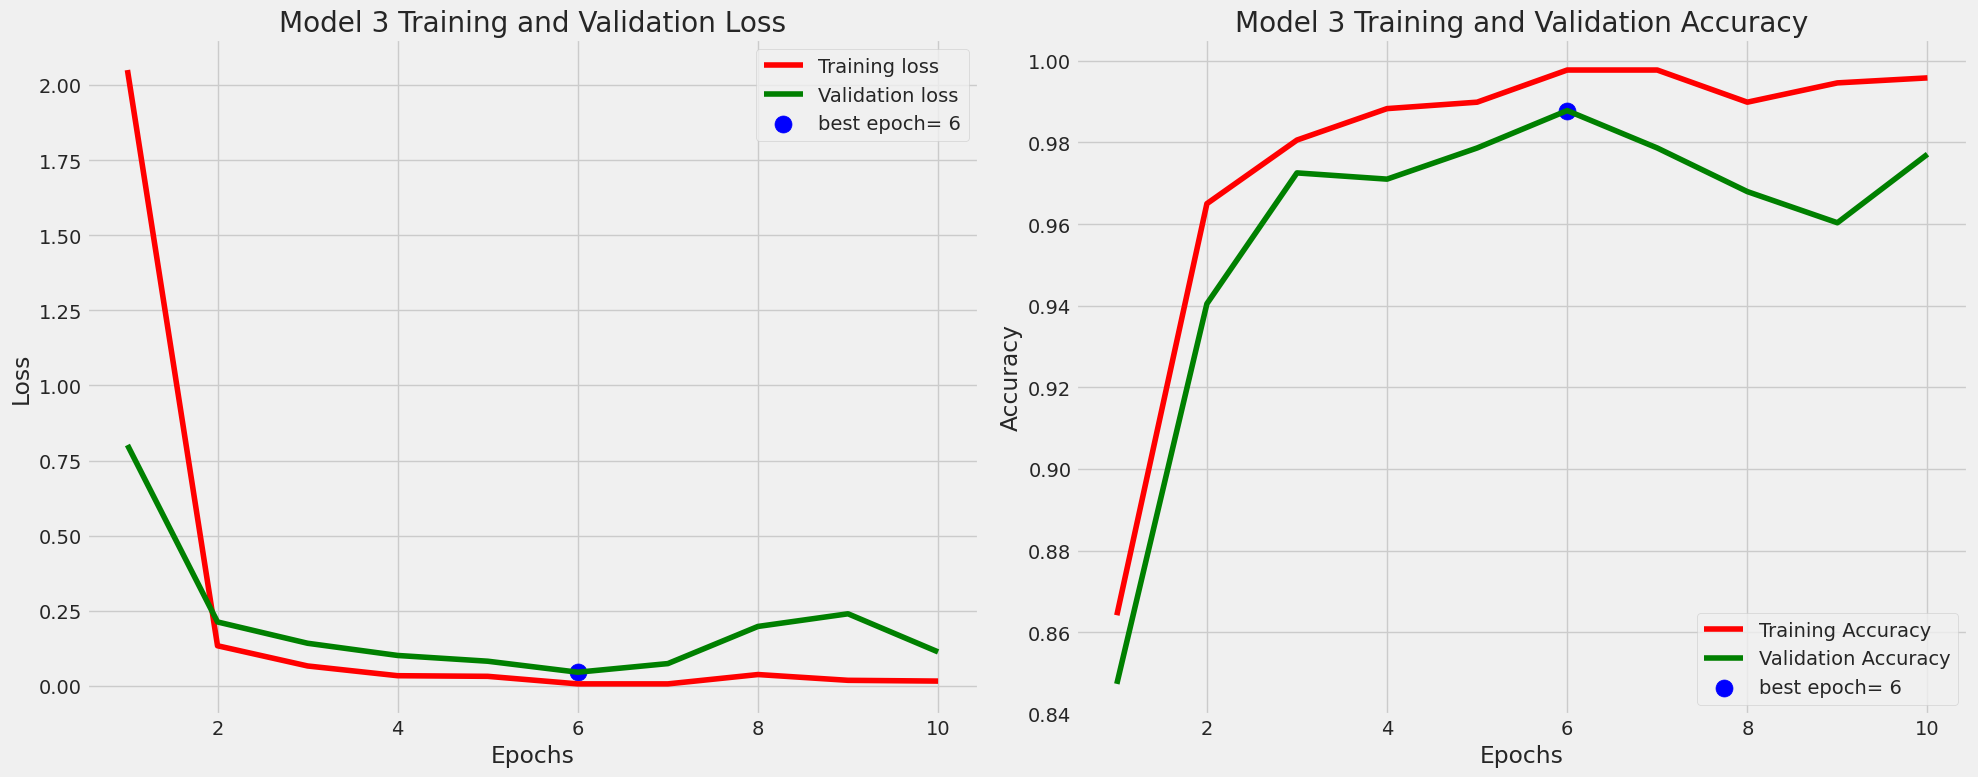

In [ ]:
# Define needed variables for model3
tr_acc_model3 = history3.history['accuracy']
tr_loss_model3 = history3.history['loss']
val_acc_model3 = history3.history['val_accuracy']
val_loss_model3 = history3.history['val_loss']
index_loss_model3 = np.argmin(val_loss_model3)
val_lowest_model3 = val_loss_model3[index_loss_model3]
index_acc_model3 = np.argmax(val_acc_model3)
acc_highest_model3 = val_acc_model3[index_acc_model3]

Epochs_model3 = [i+1 for i in range(len(tr_acc_model3))]
loss_label_model3 = f'best epoch= {str(index_loss_model3 + 1)}'
acc_label_model3 = f'best epoch= {str(index_acc_model3 + 1)}'

# Plot training history for model3
plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs_model3, tr_loss_model3, 'r', label='Training loss')
plt.plot(Epochs_model3, val_loss_model3, 'g', label='Validation loss')
plt.scatter(index_loss_model3 + 1, val_lowest_model3, s=150, c='blue', label=loss_label_model3)
plt.title('Model 3 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs_model3, tr_acc_model3, 'r', label='Training Accuracy')
plt.plot(Epochs_model3, val_acc_model3, 'g', label='Validation Accuracy')
plt.scatter(index_acc_model3 + 1, acc_highest_model3, s=150, c='blue', label=acc_label_model3)
plt.title('Model 3 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## Evaluate Model

In [ ]:
##CNN
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

357/357 ━━━━━━━━━━━━━━━━━━━━ 26s 71ms/step - accuracy: 0.9677 - loss: 0.1166
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.8754 - loss: 0.7274
41/41 ━━━━━━━━━━━━━━━━━━━━ 250s 6s/step - accuracy: 0.8837 - loss: 0.4460
Train Loss:  0.10401768982410431
Train Accuracy:  0.968137264251709
--------------------
Validation Loss:  0.6018328666687012
Validation Accuracy:  0.8839694857597351
--------------------
Test Loss:  0.48401135206222534
Test Accuracy:  0.8826219439506531


In [ ]:
#MLP Tensorflow
train_score_model2 = model2.evaluate(train_gen, verbose=1)
valid_score_model2 = model2.evaluate(valid_gen, verbose=1)
test_score_model2 = model2.evaluate(test_gen, verbose=1)

print("Model 2 Train Loss: ", train_score_model2[0])
print("Model 2 Train Accuracy: ", train_score_model2[1])
print('-' * 20)
print("Model 2 Validation Loss: ", valid_score_model2[0])
print("Model 2 Validation Accuracy: ", valid_score_model2[1])
print('-' * 20)
print("Model 2 Test Loss: ", test_score_model2[0])
print("Model 2 Test Accuracy: ", test_score_model2[1])


357/357 ━━━━━━━━━━━━━━━━━━━━ 26s 72ms/step - accuracy: 0.9062 - loss: 8.9091
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.8309 - loss: 35.1936
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.8107 - loss: 21.1067
Model 2 Train Loss:  9.494762420654297
Model 2 Train Accuracy:  0.8998599648475647
--------------------
Model 2 Validation Loss:  37.63202667236328
Model 2 Validation Accuracy:  0.8274809122085571
--------------------
Model 2 Test Loss:  23.026342391967773
Model 2 Test Accuracy:  0.8201219439506531


In [ ]:
#VGG16
train_score_model3 = model3.evaluate(train_gen, verbose=1)
valid_score_model3 = model3.evaluate(valid_gen, verbose=1)
test_score_model3 = model3.evaluate(test_gen, verbose=1)

print("Model 3 Train Loss: ", train_score_model3[0])
print("Model 3 Train Accuracy: ", train_score_model3[1])
print('-' * 20)
print("Model 3 Validation Loss: ", valid_score_model3[0])
print("Model 3 Validation Accuracy: ", valid_score_model3[1])
print('-' * 20)
print("Model 3 Test Loss: ", test_score_model3[0])
print("Model 3 Test Accuracy: ", test_score_model3[1])


357/357 ━━━━━━━━━━━━━━━━━━━━ 38s 107ms/step - accuracy: 0.9997 - loss: 0.0014
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - accuracy: 0.9717 - loss: 0.1226
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.9638 - loss: 0.1672
Model 3 Train Loss:  0.0021988647058606148
Model 3 Train Accuracy:  0.9992997050285339
--------------------
Model 3 Validation Loss:  0.11308369040489197
Model 3 Validation Accuracy:  0.9770992398262024
--------------------
Model 3 Test Loss:  0.19817779958248138
Model 3 Test Accuracy:  0.9618902206420898


## Get Predictions

In [ ]:
#CNN
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step


In [ ]:
#MLP
preds_model2 = model2.predict(test_gen)
y_pred_model2 = np.argmax(preds_model2, axis=1)


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step


In [ ]:
#VGG16
preds_model3 = model3.predict(test_gen)
y_pred_model3 = np.argmax(preds_model3, axis=1)


41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step


## Confusion Matrices and Classification report

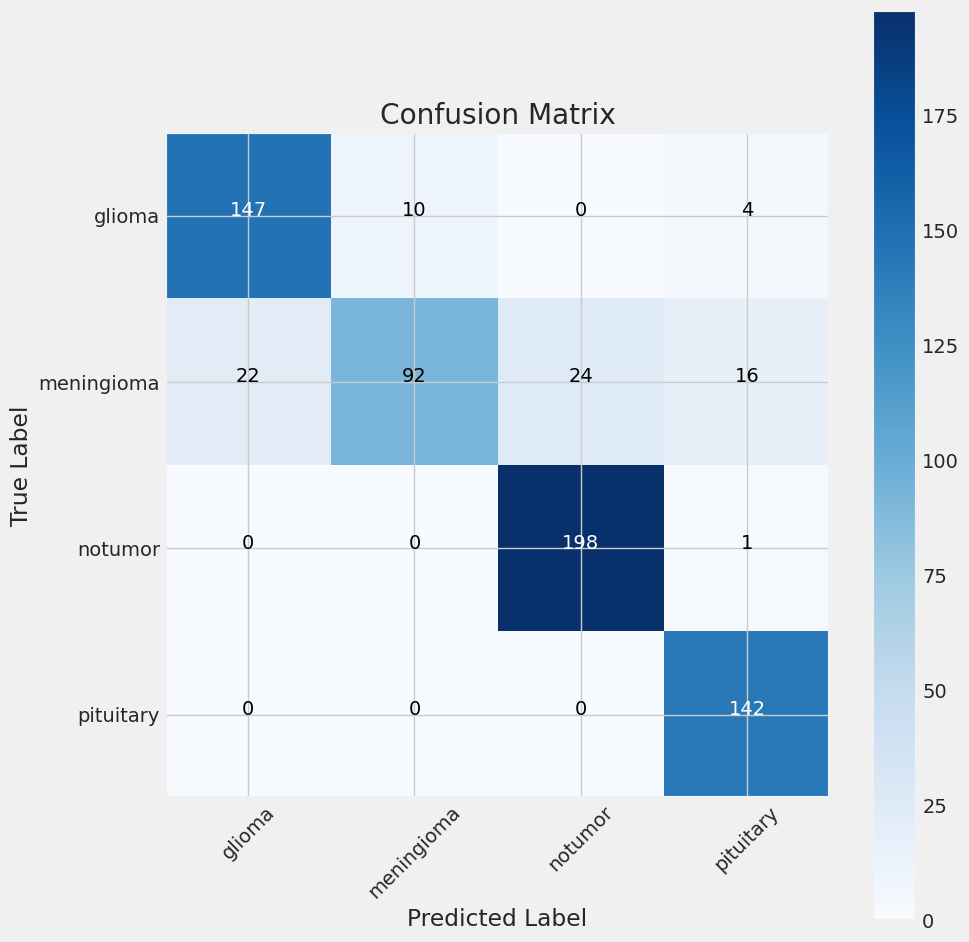

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
cm

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')


plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

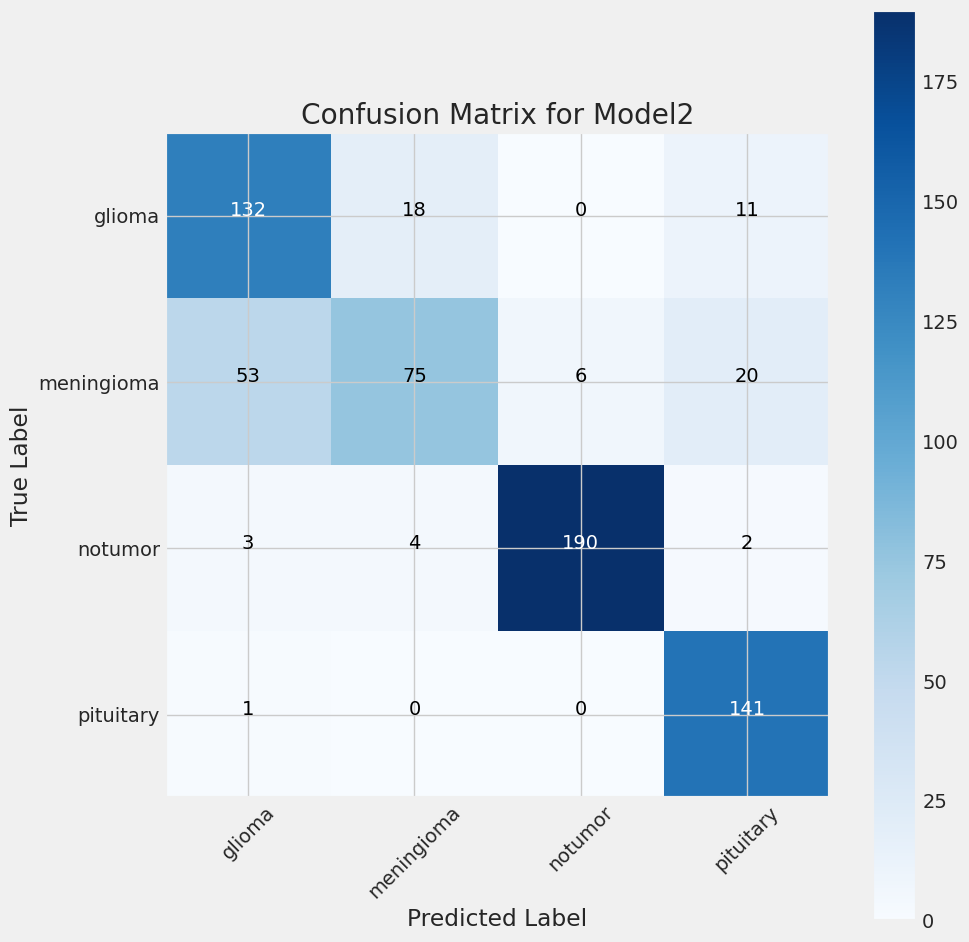

In [ ]:
g_dict_model2 = test_gen.class_indices
classes_model2 = list(g_dict_model2.keys())

# Confusion matrix for model2
cm_model2 = confusion_matrix(test_gen.classes, y_pred_model2)
cm_model2

plt.figure(figsize= (10, 10))
plt.imshow(cm_model2, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix for Model2')
plt.colorbar()

tick_marks_model2 = np.arange(len(classes_model2))
plt.xticks(tick_marks_model2, classes_model2, rotation= 45)
plt.yticks(tick_marks_model2, classes_model2)

thresh_model2 = cm_model2.max() / 2.
for i, j in itertools.product(range(cm_model2.shape[0]), range(cm_model2.shape[1])):
    plt.text(j, i, cm_model2[i, j], horizontalalignment= 'center', color= 'white' if cm_model2[i, j] > thresh_model2 else 'black')


plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()


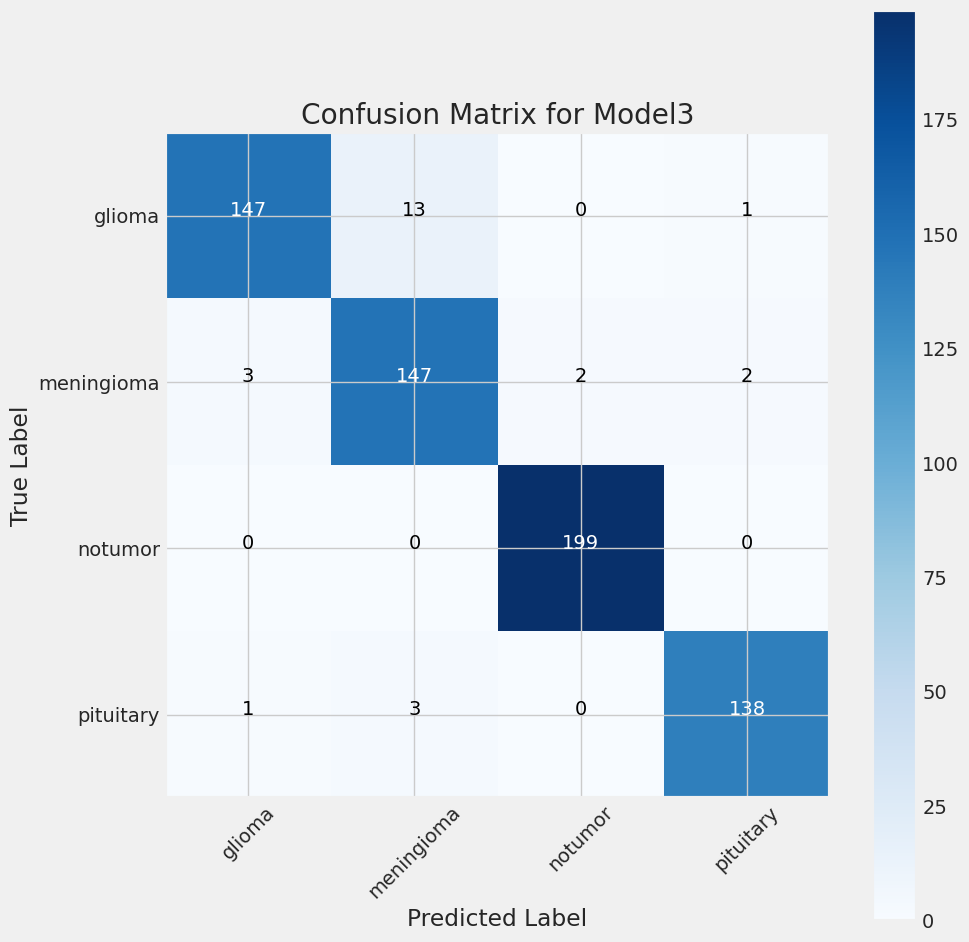

In [ ]:
g_dict_model3 = test_gen.class_indices
classes_model3 = list(g_dict_model3.keys())

# Confusion matrix for model3
cm_model3 = confusion_matrix(test_gen.classes, y_pred_model3)
cm_model3

plt.figure(figsize= (10, 10))
plt.imshow(cm_model3, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix for Model3')
plt.colorbar()

tick_marks_model3 = np.arange(len(classes_model3))
plt.xticks(tick_marks_model3, classes_model3, rotation= 45)
plt.yticks(tick_marks_model3, classes_model3)

thresh_model3 = cm_model3.max() / 2.
for i, j in itertools.product(range(cm_model3.shape[0]), range(cm_model3.shape[1])):
    plt.text(j, i, cm_model3[i, j], horizontalalignment= 'center', color= 'white' if cm_model3[i, j] > thresh_model3 else 'black')


plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()


In [ ]:
#CNN Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      glioma       0.87      0.91      0.89       161
  meningioma       0.90      0.60      0.72       154
     notumor       0.89      0.99      0.94       199
   pituitary       0.87      1.00      0.93       142

    accuracy                           0.88       656
   macro avg       0.88      0.88      0.87       656
weighted avg       0.88      0.88      0.87       656



In [ ]:
#MLP Classificatoin Report
print(classification_report(test_gen.classes, y_pred_model2, target_names= classes_model2))


              precision    recall  f1-score   support

      glioma       0.70      0.82      0.75       161
  meningioma       0.77      0.49      0.60       154
     notumor       0.97      0.95      0.96       199
   pituitary       0.81      0.99      0.89       142

    accuracy                           0.82       656
   macro avg       0.81      0.81      0.80       656
weighted avg       0.82      0.82      0.81       656



In [ ]:
#VGG16 Classification Report
print(classification_report(test_gen.classes, y_pred_model3, target_names= classes_model3))


              precision    recall  f1-score   support

      glioma       0.97      0.91      0.94       161
  meningioma       0.90      0.95      0.93       154
     notumor       0.99      1.00      0.99       199
   pituitary       0.98      0.97      0.98       142

    accuracy                           0.96       656
   macro avg       0.96      0.96      0.96       656
weighted avg       0.96      0.96      0.96       656

